# WTFAE: Flo's data

**Goal:** In WTFAE-2 I _sanity checked_ that I could reproduce the training of the nb Lukas gave me.

**Next:** Pop in Flo's generation function, and see if I can get similar results for the decoder with _his_ blobs.

**What will this diagnose?** I think mostly this will diagnose if I implemented the loss function correctly, although

**What next?** If this works, I _could_ take the pretrained encoder weights and slot representation, and then try to add a final semantic segmentation classifer?


**Saras comment**: let's walk through to understand loss better to implement discovery mode in ISA!

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#device='cuda:1'
device='cpu'

In [3]:
nPixels = 32

xlow = -0.5
xhigh = 0.5
binWidth = (xhigh-xlow)/(nPixels+1)

bins = np.arange(xlow,xhigh,binWidth)


In [4]:
# args for rings
kwargs={'N_clusters':2,
        # 'isRing':False,
        # 'device':device, 
        # 'stdlow':0.001,
        # 'stdhigh':0.005
       }

In [5]:
def my_gen_data(
    bins=np.arange(xlow,xhigh,binWidth),
    N_events = 100000,
    N_clusters = 1,
    mean_var_cluster = np.log(0.001),
    sigma_var_cluster = 0.1,
    mean_lam_cluster = np.log(200.),
    sigma_lam_cluster = 1.,
    isRing=True,
    blurImage=False,
    xlow=-.5,
    xhigh=0.5,
    stdlow=0.01,
    stdhigh=0.05,
    device='cpu'
):
    '''
    Starts from Florian's `gen_events` function
    https://gitlab.lrz.de/neural_network_clustering/permutation_invariant_loss/-/blob/main/test_blur.ipynb
    
    But I wanted to return the occupancy maps that you multiply the OG image by to output partitioning
    of the image into the OG ring signals.
    '''

    eventHistograms = np.zeros(shape=(N_events, len(bins)-1, len(bins)-1,1) ) 
    
    eventMasks = np.zeros(shape=(N_events, N_clusters, len(bins)-1, len(bins)-1) ) 
    
    eventNumbers = np.zeros(N_events)

    nMaxClusters = N_clusters   
    
    eventInfo = np.zeros(shape=(N_events, nMaxClusters, 3))
    
    for iEvent in range(N_events):
        
        image = np.zeros_like(eventHistograms[iEvent,:,:,0])
        
        n_clusters = nMaxClusters

        eventNumbers[iEvent] += n_clusters
        eI = []
        
        for iCluster in range(min(n_clusters,nMaxClusters)):
            
            # how many events in this cluster
            lam_N_events_in_cluster = 1e3 
            
            N_events_in_cluster = np.random.poisson(lam_N_events_in_cluster)

            # where is the cluster center
            cluster_center = np.random.uniform(low=xlow, high=xhigh, size=2)

            # what is the cluster spread
            var_cluster = np.random.uniform(stdlow,stdhigh) 
            
            cluster_events_x0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)
            cluster_events_y0 = np.random.normal(loc=0., scale=1., size=N_events_in_cluster)

            if isRing:
                fact = np.sqrt(var_cluster/(cluster_events_x0**2+cluster_events_y0**2))
            else:
                fact = np.sqrt(var_cluster)

            cluster_events_x = cluster_events_x0*fact + cluster_center[0]
            cluster_events_y = cluster_events_y0*fact + cluster_center[1]
            
            # bin the events
            H, _, _ = np.histogram2d(cluster_events_x, cluster_events_y, bins=[bins,bins])

            eventMasks[iEvent,iCluster] = H.T
            image += H.T
                        
            eI.append(np.concatenate([cluster_center, [var_cluster]]))

        eventHistograms[iEvent,:,:,0] = np.copy(image)

        eventInfo[iEvent] = np.array(eI)
    
    # reshape eventHistograms
    eventHistograms = eventHistograms[:,None,:,:,0] # shape (bs, 1, nPixels, nPixels)
    
    eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
    
    return eventHistograms, eventInfo, eventMasks

In [6]:
out = my_gen_data(N_events=123,N_clusters=2)

/tmp/ipykernel_34961/316785512.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [7]:
[oi.shape for oi in out]

[(123, 1, 32, 32), (123, 2, 3), (123, 2, 32, 32)]

In [10]:
def make_batch(
        Nbatch = 34,
        data_mean = torch.FloatTensor([0,0,0,0,3]),
        data_std = torch.FloatTensor([1,1,1,1,1])
    ):
    
    # Get the energies from Flo's scrip
    E, trgt, masks = my_gen_data(N_events=Nbatch,**kwargs)
    
    # Calc the grid w/ LH's calc
    bins = [np.linspace(0,1,nPixels+1)]*2
    _ed = np.linspace(0,1,nPixels+1)
    _ct = _ed[:-1] + np.diff(_ed)/2
    grid = np.meshgrid(*[_ct]*2, indexing='ij')
    
    grid = [np.tile(gi,(Nbatch,1,1))[:,None] for gi in grid]
    
    # log the energies and concatenate them
    logE = np.log(E + 1e-2)
    
    c = np.hstack([grid[0],grid[1], 1-grid[0],1-grid[1],logE])

    # Convert to Tensors
    data = torch.FloatTensor(c)
    trgt = torch.FloatTensor(trgt)
    
    return data.to(device), trgt.to(device)
make_batch(123)[0].shape, make_batch(123)[1].shape

/tmp/ipykernel_34961/316785512.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


(torch.Size([123, 5, 32, 32]), torch.Size([123, 2, 3]))

In [11]:
class TrivialSlotEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 2
                
        self.hidden_dim = 4
        self.encoder1 = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )
        self.encoder2 = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear((nPixels**2)*self.hidden_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,self.latent_dim)
        )   
        
    def forward(self, data):
        encoded_data = self.encoder1(data)
        positions = self.encoder2(encoded_data)
        positions = positions.unsqueeze(1)
        return positions

In [12]:
class SlotAttentionEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.k_slots = 3
        self.latent_dim = 32
        self.hidden_dim = 32
        self.query_dim = 32
        self.slot_dim = 32
        self.n_iter = 1

        self.queryN = torch.nn.LayerNorm(self.query_dim)
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.updateN = torch.nn.LayerNorm(self.query_dim)

        self.toK = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim,self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(5,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,5, padding = 2),
        )   
        
        self.final = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.slot_dim)
        )

        self.updateff = torch.nn.Sequential(
            torch.nn.Linear(self.query_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,self.query_dim)
        )
        
    def init_slots(self, Nbatch):
        noise = torch.randn(Nbatch, self.k_slots, self.query_dim).to(device)
        
        mu = torch.zeros(1,1,self.query_dim).to(device)
        logsigma = torch.zeros(1,1,self.query_dim).to(device)
        
        return mu + noise*logsigma.exp()


    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        att = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) * 10
        att = torch.nn.functional.softmax(att, dim = 1)

        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)        
        vals = self.toV(encoded_data)
        extracted = torch.einsum('bsd,bde->bse',wts,vals)
        
        extracted = self.gru(
            extracted.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return extracted.reshape(queries.shape)
        
    def forward(self, data):
        Nbatch = data.shape[0]
        queries = self.init_slots(Nbatch)
        encoded_data = self.encoder(data)
        queries = self.iterate(queries, encoded_data)
        queries = self.iterate(queries, encoded_data)
        positions = self.final(queries)
        return positions,queries
        
SlotAttentionEncoder().to(device)(torch.randn(123,5,nPixels,nPixels,device=device))[0].shape

torch.Size([123, 3, 32])

In [13]:
TrivialSlotEncoder().to(device)(torch.randn(123,5,nPixels,nPixels,device=device)).shape

torch.Size([123, 1, 2])

In [14]:
class AttModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 32

        self.encoder = SlotAttentionEncoder()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,128),
            torch.nn.ReLU(),
            torch.nn.Linear(128,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256,nPixels**2),
            torch.nn.Unflatten(-1,(nPixels,nPixels))
        )
        

    def forward(self, data):
        Nbatch, *_ = data.shape
        positions,queries = self.encoder(data)
        decoded = self.decoder(positions)
        reco = decoded.sum(dim = 1)
        return reco,queries,decoded

AttModel().to(device).encoder(make_batch(123)[0])[0].shape

/tmp/ipykernel_34961/316785512.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


torch.Size([123, 3, 32])

In [19]:
data, trgt = make_batch(4)

/tmp/ipykernel_34961/316785512.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [20]:
data.shape

torch.Size([4, 5, 32, 32])

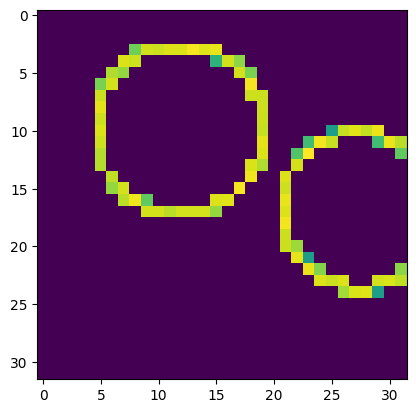

In [28]:
plt.imshow(data[1, 4]) # 4 bilder, 4ter eintrag die ringe, ka was die 4 farbverlaufe davor sollen.

In [16]:
def plotit(batchidx, model, data, losses):
    with torch.no_grad():
        model.eval()
        pred,queries,decoded = model(data)
        encoded_data = model.encoder.encoder(data)
        encoded_data = torch.permute(encoded_data,(0,2,3,1))
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = model.encoder.dataN(encoded_data)
        att,wts = model.encoder.attention_and_weights(queries,encoded_data)
#         print(wts.sum(dim=-1).max(),'max')
        att = att.reshape(len(att),3,nPixels,nPixels)
        wts = wts.reshape(len(att),3,nPixels,nPixels)
        
        crap = model.decoder(torch.randn(2,model.encoder.k_slots,model.encoder.slot_dim,device=device))
        
    f,axarr = plt.subplots(3,6)
    ax = axarr[0,0]
    ax.plot(losses)
    ax.set_yscale('log')
    ax.axis('off')
    ax = axarr[0,1]
    ax.pcolormesh(data[batchidx,-1].cpu(), vmin = -3, vmax = 3)
    ax.axis('off')
    ax = axarr[0,2]
    ax.pcolormesh(pred[batchidx].cpu(), vmin = -3, vmax = 3)
    ax.axis('off')
    for i in range(3):
        ax = axarr[0,3+i]
        ax.pcolormesh(att[batchidx,i].cpu(), vmin = 0, vmax = 1)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,3+i]
        print(wts.min(),wts.max(),'>>><<')
        ax.pcolormesh(wts[batchidx,i].cpu(), vmin = 0, vmax = .001)
        ax.axis('off')
    for i in range(3):
        ax = axarr[1,i]
        ax.axis('off')
        ax = axarr[2,i]
        ax.axis('off')
    ax = axarr[1,0]
    ax.pcolormesh(crap[batchidx,0].cpu())

    ax = axarr[1,2]
    ax.pcolormesh(decoded.sum(dim=1)[batchidx].cpu(), vmin = -3, vmax = 3)
    for i in range(3):
        ax = axarr[2,3+i]
        ax.pcolormesh(decoded[batchidx,i].cpu(), vmin = -3, vmax = 3)
        ax.axis('off')
    f.set_size_inches(6,3)
    plt.show()    

def train(model, Ntrain = 5000):
    opt = torch.optim.Adam(model.parameters(), 3e-4)
    model.train()
    losses = []
    for i in range(Ntrain):
        
        warmup_steps = 5000
        learning_rate = 3e-4
        if i < warmup_steps:
            learning_rate = learning_rate * (i / warmup_steps)
        else:
            learning_rate = learning_rate
        opt.param_groups[0]['lr'] = learning_rate

        
        data, trgt = make_batch(4)
        print("data shape: ", data.shape)
        pred,*_ = model(data)
        print("prediction shape: ", pred.shape)
        loss = torch.nn.functional.mse_loss(
            data[:,-1,...],
            pred
        )
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        losses.append(float(loss))
        if i % 250 == 0:
            print('loss',i,loss,opt.param_groups[0]['lr'])
            plotit(0,model,data,losses)
            plotit(1,model,data,losses)

    model.eval()
    return model,losses

In [17]:
# with torch.no_grad():
#     data, trgt = make_batch(4)
#     pred,*_ = model(data)

/tmp/ipykernel_34961/316785512.py:83: RuntimeWarning: invalid value encountered in divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
loss 0 tensor(20.4299, grad_fn=<MseLossBackward0>) 0.0
tensor(3.9065e-07) tensor(0.0649) >>><<
tensor(3.9065e-07) tensor(0.0649) >>><<
tensor(3.9065e-07) tensor(0.0649) >>><<


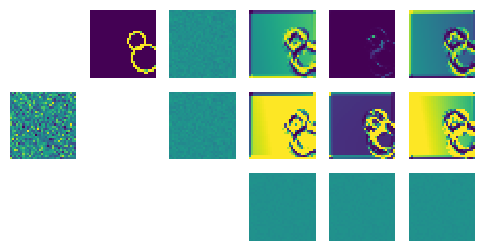

tensor(3.5489e-07) tensor(0.0329) >>><<
tensor(3.5489e-07) tensor(0.0329) >>><<
tensor(3.5489e-07) tensor(0.0329) >>><<


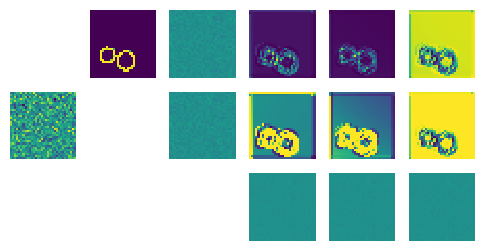

data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data

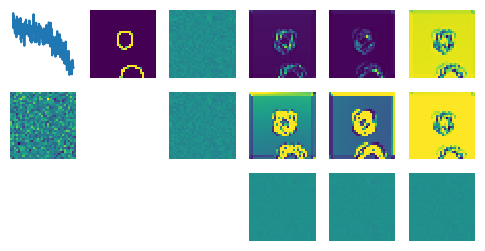

tensor(3.4455e-07) tensor(0.0791) >>><<
tensor(3.4455e-07) tensor(0.0791) >>><<
tensor(3.4455e-07) tensor(0.0791) >>><<


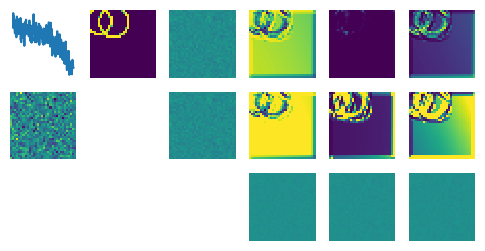

data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data

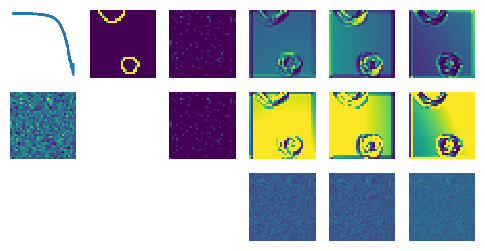

tensor(1.9075e-06) tensor(0.0112) >>><<
tensor(1.9075e-06) tensor(0.0112) >>><<
tensor(1.9075e-06) tensor(0.0112) >>><<


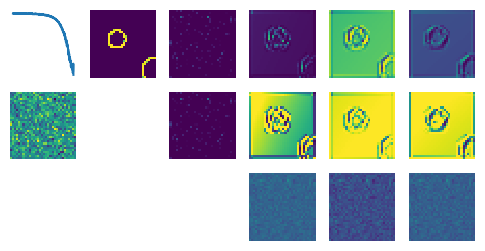

data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data

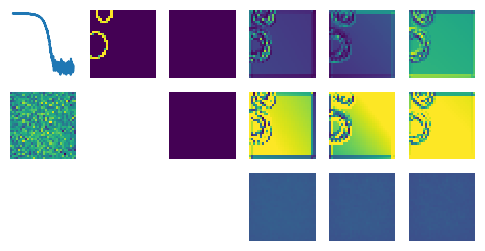

tensor(4.9700e-06) tensor(0.0306) >>><<
tensor(4.9700e-06) tensor(0.0306) >>><<
tensor(4.9700e-06) tensor(0.0306) >>><<


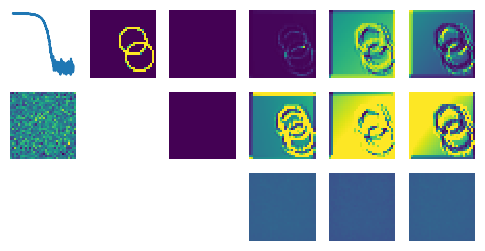

data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data shape:  torch.Size([4, 5, 32, 32])
prediction shape:  torch.Size([4, 32, 32])
data

KeyboardInterrupt: 

In [18]:
model = AttModel().to(device)
model,*_rest = train(model,100_000)

In [ ]:
# all-track fit :  is it a compromise just to make 

In [ ]:
!